### Installing Pre-requisites and Importing Libraries

In [1]:
!pip install kaggle -q

In [2]:
import plotly.express as px
import pandas as pd
import numpy as np
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go

### Import data from Kaggle

In [3]:
!mkdir -p ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d yasserh/customer-segmentation-dataset

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
 78% 17.0M/21.8M [00:00<00:00, 56.2MB/s]
100% 21.8M/21.8M [00:00<00:00, 64.9MB/s]


In [4]:
!unzip /content/customer-segmentation-dataset.zip

Archive:  /content/customer-segmentation-dataset.zip
  inflating: Online Retail.xlsx      


In [5]:
data_path = "/content/Online Retail.xlsx"

In [6]:
df = pd.read_excel(data_path)
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

### Functions

In [7]:
def remove_outliers(df, column_name, multiplier=1.5):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return filtered_df

In [8]:
def bar_plot(df,col):
  '''
  Description : This Function creates a bar plot with specific colors and highlight the bar with most values

  parameters : 
    col  : Column from dataframe
    df   : Dataframe
    xticks : xticks labels in a list

  returns a fig in plotly 

  '''
  fig = px.bar(df,
              x = [i for i in df[col].value_counts().index] ,
              y = [i for i in df[col].value_counts().values] ,
              width=500,
              height=500,
              color_discrete_sequence =[['blue']],
              labels= {'x':f'{col}', 'y': 'Count'},
              text_auto = True,
              opacity = 0.8,
              template='plotly_white'
       )
  fig.update_traces(textfont_size=12, textangle=0, textposition="auto")
  fig.update_layout(
      xaxis = dict(
          tickmode = 'array',
          tickvals = [i for i in df[col].value_counts().index],
          # ticktext = xticks
      )
  )
  return fig

### Data Exploration

##### .head()

- We have a dataset with 8 features and over 500,000 rows

- The `InvoiceNo` and `InvoiceDate` columns indicate the specific time when a customer made a purchase

- The `StockCode` column serves as a unique identifier for each product (SKU). The "Quantity" and `UnitPrice` columns represent the quantity of a product purchased and the corresponding price. 

- The `Country` column indicates the origin of the orders, specifying the country where the purchases were made.

In [9]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

##### .shape

- `Online retail` dataset has `541909` rows and `9` columns

In [10]:
df.shape

(541909, 8)

##### .info()

- There are 5 discrete variable and 3 continuous variable
- We can reduce dtype of some column for fewer memory space but this is not needed here, as we have less amount of data.


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


##### .describe()

- Based on describe method of pandas dataframe it appears that `Quantity` and `UnitPrice` columns contains extreme values both in positive and negative direction shows higher variation from mean and standard deviation which are most likely to be outliers in the dataset. Hence, we need to remove these outliers

In [12]:
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

##### .isnull()
- `CustomerID` column has highest number of null values of around 135080
- We will try to identify `CustomerID` through `InvoiceNo` As `InvoiceNo` is same within each purchase made by a customer

In [13]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

##### .unique() and .nunique()

- We have approximately 25,000 unique "InvoiceNo" entries, indicating a total of 25,000 purchases made in our dataset.

- Our dataset offers over 4,000 different products.

- The number of descriptions in our dataset exceeds the number of unique stock codes, suggesting that some items may have one or more descriptions.

- We have a total of 4,372 unique customers in our dataset.

- Stores as per data are located in 38 different countries.

In [14]:
dic = {}
for i in df.columns:
  dic[i] = df[i].nunique()

dic

{'InvoiceNo': 25900,
 'StockCode': 4070,
 'Description': 4223,
 'Quantity': 722,
 'InvoiceDate': 23260,
 'UnitPrice': 1630,
 'CustomerID': 4372,
 'Country': 38}

##### .duplicated()
- There are no duplicate values in our dataset

In [15]:
df.duplicated().sum()

5268

### Data Pre-Processing and Feature Engineering

#### Data Removal

- Total rows after data removal - 444485

##### Removing duplicate values
- We have removed around 5268 Duplicate values which is around 0.9% of the total rows in our dataset

In [16]:
df.drop_duplicates(inplace = True)

##### Removing unwanted rows or rows with anamoly

- We have also seen some anomaly in unitprice and customerID. We will drop values with 0.0 unitprice and customerId as nan
- We have removed around 0.45% values from our dataset by this process

In [17]:
df = df[~((df['UnitPrice'] == 0.0) & (df['CustomerID'].isnull() == True))]

##### Treating Null values

- Description : We can check if there are other rows with the same "StockCode" and use the description from those rows to fill in the missing values

- We can group by invoice no as it is unique identitfier when a customer makes purchase. We can any random value to group by `invoice id` using min and max range from `customer id`. As it will help us mimic the actual `customer id` 
- Most of the null values when country is United Kingdom

In [18]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132567
Country             0
dtype: int64

##### Description Column

In [19]:
for index, row in df[df['Description'].isnull()].iterrows():
    stock_code = row['StockCode']
    matching_rows = df[(df['StockCode'] == stock_code) & df['Description'].notnull()]
    if not matching_rows.empty:
        df.at[index, 'Description'] = matching_rows.iloc[0]['Description']

##### CustomerID Column

- CustomerID ranging from 12345 till 18287 , which is about 5 figures. We will randomly select a value from this range and fill customerId whenever null is present

In [20]:
df['CustomerID'].min() , df['CustomerID'].max()

(12346.0, 18287.0)

In [21]:
Cus_id_null = df[(df['CustomerID'].isnull() == True) & (df['UnitPrice'] != 0.0)]
Cus_id_null.head()

InvoiceNo StockCode                      Description  Quantity  \
1443    536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444    536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445    536544     21786               POLKADOT RAIN HAT          4   
1446    536544     21787            RAIN PONCHO RETROSPOT         2   
1447    536544     21790               VINTAGE SNAP CARDS         9   

             InvoiceDate  UnitPrice  CustomerID         Country  
1443 2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1444 2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1445 2010-12-01 14:32:00       0.85         NaN  United Kingdom  
1446 2010-12-01 14:32:00       1.66         NaN  United Kingdom  
1447 2010-12-01 14:32:00       1.66         NaN  United Kingdom

In [22]:
Cus_id_null.groupby('InvoiceNo')['StockCode'].count().sort_values(ascending = False).head(10)

InvoiceNo
573585    1114
581219     749
581492     731
580729     721
558475     705
579777     687
581217     676
537434     675
580730     662
538071     651
Name: StockCode, dtype: int64

In [23]:
random_ids = np.random.randint(10000, 20000, size=df['CustomerID'].isnull().sum())
random_ids = ['{:05d}'.format(id) for id in random_ids]
df.loc[df['CustomerID'].isnull(), 'CustomerID'] = random_ids

##### Outlier Removal

- Quantity and UnitPrice contains some unsual values as highlighted by min and max of the column.

- Quantity have min values as -80995 and max value as 80995. Which demonstrates outliers in this column

- UnitPrice have min values as -11062 and max value as 38970. Which demonstrates outliers in this column

- We'll use IQR to remove outliers

In [24]:
df.describe()

Quantity      UnitPrice
count  534171.000000  534171.000000
mean        9.942034       4.654077
std       217.122291      97.457150
min    -80995.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.100000
75%        10.000000       4.130000
max     80995.000000   38970.000000

In [25]:
df_ = remove_outliers(df,"Quantity")
df_.describe()

Quantity      UnitPrice
count  476833.000000  476833.000000
mean        4.611011       5.054857
std         4.545070     103.137587
min       -12.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.460000
75%         6.000000       4.210000
max        23.000000   38970.000000

In [26]:
df_1 = remove_outliers(df_,"UnitPrice")
df_1.describe()

Quantity      UnitPrice
count  444485.000000  444485.000000
mean        4.809006       2.795327
std         4.600945       2.040365
min       -12.000000       0.000000
25%         1.000000       1.250000
50%         3.000000       2.100000
75%         8.000000       3.810000
max        23.000000       8.620000

In [27]:
df = df_1.copy()

#### Feature Extraction

- We will extract Year , Month Name , Day Name , Hour , Quarter , Weekends or Weekday from invoice date column.

- We will generate Total Purchase of each item by multiplying unitprice with quantity

In [28]:
df.loc[:, 'Year'] = df['InvoiceDate'].dt.year
df.loc[:, 'Month'] = df['InvoiceDate'].dt.month
df.loc[:, 'Date'] = df['InvoiceDate'].dt.day
df.loc[:, 'Hour'] = df['InvoiceDate'].dt.hour
df.loc[:, 'Month_Name'] = df['InvoiceDate'].dt.month_name()
df.loc[:, 'Day_Name'] = df['InvoiceDate'].dt.day_name()
df.loc[:, 'Quarter_Of_Year'] = df['InvoiceDate'].dt.quarter
df.loc[:, 'Week_Type'] = np.where(df['Day_Name'].isin(['Friday', 'Saturday', 'Sunday']), 'Weekend', 'Weekday')
df.loc[:, 'Total Purchase'] = df['UnitPrice'] * df['Quantity']

#### Data type conversion
- Except for `CustomerID`, the most of the columns have correct data types. Its data type will be changed from float to int 

In [29]:
df['CustomerID'] = df['CustomerID'].astype('int32')

### EDA

##### Univariate Analysis
- We would use univariate data analysis for a descriptive study on how one characteristic or attribute varies or to examine how each characteristic or attribute varies before including that variable in a study with two or more variables.

- The three months of Oct, Nov, and Dec have the largest annual sales, at about $50,000, $75,000, and $56,000, respectively.

- During the week, people used to spend more, with 321K in sales overall. The preferred days are Monday, Tuesday, and Thursday.

- The highest increase in overall purchases, of almost 421K, occurred in 2011.

- The biggest total sales, of almost 176K, were in the fourth quarter.

- United Kingdom, Germany, and France made up the majority of sales.

In [30]:
from plotly.subplots import make_subplots



fig1 = bar_plot(df,"Month_Name")
fig2 = bar_plot(df,"Week_Type")
fig3 = bar_plot(df,"Year")
fig4 = bar_plot(df,"Quarter_Of_Year")
fig5 = bar_plot(df,"Day_Name")
fig6 = bar_plot(df,"Country")



figure1_traces = [fig1["data"][trace] for trace in range(len(fig1["data"]))]
figure2_traces = [fig2["data"][trace] for trace in range(len(fig2["data"]))]
figure3_traces = [fig3["data"][trace] for trace in range(len(fig3["data"]))]
figure4_traces = [fig4["data"][trace] for trace in range(len(fig4["data"]))]
figure5_traces = [fig5["data"][trace] for trace in range(len(fig5["data"]))]
figure6_traces = [fig6["data"][trace] for trace in range(len(fig6["data"]))]


this_figure = make_subplots(rows = 3, cols = 2,row_titles=['Count'])
this_figure.update_layout(height = 1500, width = 1200, title_text = 'Univariate Categorical Columns Analysis', title_font_size = 25)


this_figure.update_xaxes(title_text="Month", row=1, col=1)
this_figure.update_xaxes(title_text="Week", row=1, col=2)
this_figure.update_xaxes(title_text="Year", row=2, col=1)
this_figure.update_xaxes(title_text="Quarter_Of_Year", row=2, col=2)
this_figure.update_xaxes(title_text="Day_Name", row=3, col=1)
this_figure.update_xaxes(title_text="Country", row=3, col=2)



for traces in figure1_traces:
  this_figure.append_trace(traces, row = 1, col = 1)

for traces in figure2_traces:
  this_figure.append_trace(traces, row = 1, col = 2)


for traces in figure3_traces:
  this_figure.append_trace(traces, row = 2, col = 1)

for traces in figure4_traces:
  this_figure.append_trace(traces, row = 2, col = 2)

for traces in figure5_traces:
  this_figure.append_trace(traces, row = 3, col = 1)

for traces in figure6_traces:
  this_figure.append_trace(traces, row = 3, col = 2)


this_figure.show()

##### Groupby analysis

- Highest total purchase made on InvoiceNo 573585 which is around 9460
- Top 3 Stockcodes based on total sales were 47566 , 85123A and 85099B with total sales of around 	33965.58 , 32667.09 and 32054.02 respectively
- Top 3 Stockcodes based on total loss were POST , S and 35400 with total loss in sales of around -107 , 82 and 63 respectively
- Top 3 CustomerID based on total sales were 14911	, 14096 and 17841 with total sales of around 75832 , 38358 and 31339 respectively
- Top 3 CustomerID based on total loss were 16252	, 15823 and 14460 with total lose in sales of around 217 , 138 and 36 respectively
- Top 3 countries with highest sales are - United Kingdom , Germany and France with total sales of around 4.2M , 120K and 103K respectively.

In [ ]:
pd.DataFrame(df.groupby('InvoiceNo')['Total Purchase'].sum().sort_values(ascending = False).head(10)).reset_index()

In [ ]:
pd.DataFrame(df.groupby('StockCode')['Total Purchase'].sum().sort_values(ascending = False).head(10)).reset_index()

In [ ]:
pd.DataFrame(df.groupby('StockCode')['Total Purchase'].sum().sort_values(ascending = False).tail(10)).reset_index()

In [ ]:
pd.DataFrame(df.groupby('CustomerID')['Total Purchase'].sum().sort_values(ascending = False).tail(5)).reset_index()

In [ ]:
pd.DataFrame(df.groupby('CustomerID')['Total Purchase'].sum().sort_values(ascending = False).head(5)).reset_index()

In [ ]:
pd.DataFrame(df.groupby('Country')['Total Purchase'].sum().sort_values(ascending = False).head(5)).reset_index()

In [ ]:
pd.DataFrame(df.groupby('InvoiceDate')['Total Purchase'].sum().sort_values(ascending = False).head(5)).reset_index()

In [55]:
import plotly.express as px
from plotly.subplots import make_subplots

columns = ['Quantity','UnitPrice','Total Purchase']

rows = 1
cols = 3

this_figure = make_subplots(rows=rows, cols=cols, subplot_titles=columns)
this_figure.update_layout(height=700, width=1200, title_text='Univariate Categorical Columns Analysis (Box Plot)', title_font_size=25)

for i, column in enumerate(columns, start=1):
    row = (i - 1) // cols + 1
    col = (i - 1) % cols + 1
    fig = px.box(df, x=column)
    for trace in fig['data']:
        this_figure.add_trace(trace, row=row, col=col)
    this_figure.update_xaxes(title_text=column, row=row, col=col)

this_figure.show()


#### RFM Metrics Description and Calculation

- We Will use this dataset for Our Clustering Model

- **Recency**: Recency measures how recently a customer made a purchase. It is calculated as the number of days between the customer's latest purchase date and a reference date.

> Formula: `Recency = ReferenceDate - LatestPurchaseDate`

- **Frequency**: Frequency represents how often a customer made purchases. It is calculated as the total number of purchases made by the customer.

> Formula: `Frequency = Count of Purchases`

- **Monetary**: Monetary metric represents the total amount spent by a customer. It is calculated as the sum of the purchase amounts made by the customer.

> Formula: `Monetary = Sum of Purchase Amounts`

In [58]:
df_copy = df.copy()
df_copy['TotalSum'] = df_copy['Quantity'] * df_copy['UnitPrice']
snapshot_date = df_copy['InvoiceDate'].max().date() + datetime.timedelta(days=1)

rfm_metrics = df_copy.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max().date()).days),
    Frequency=('InvoiceNo', 'count'),
    MonetaryValue=('TotalSum', 'sum')).reset_index()

rfm_metrics.head()

CustomerID  Recency  Frequency  MonetaryValue
0       10000        9         16         100.44
1       10001        1         11          84.23
2       10002        2         12         140.08
3       10003       18          9         117.74
4       10004       15         10          44.39

In [61]:
rfm_metrics = rfm_metrics.set_index('CustomerID')

### Model Building

- We'll be buidling a K-Means Model to segment our customers

In [64]:
# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rfm_metrics.iloc[:,:])

In [79]:
# Build the basic k-means model
kmeans = KMeans(n_clusters=4, random_state=42,n_init = 10)
kmeans.fit(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=4, random_state=42)

In [80]:
# Get the cluster labels
cluster_labels = kmeans.labels_

In [ ]:
# Visualize the clusters
fig = px.scatter_3d(rfm_metrics, x="Recency", y="Frequency", z="MonetaryValue", color=cluster_labels)
fig.show()

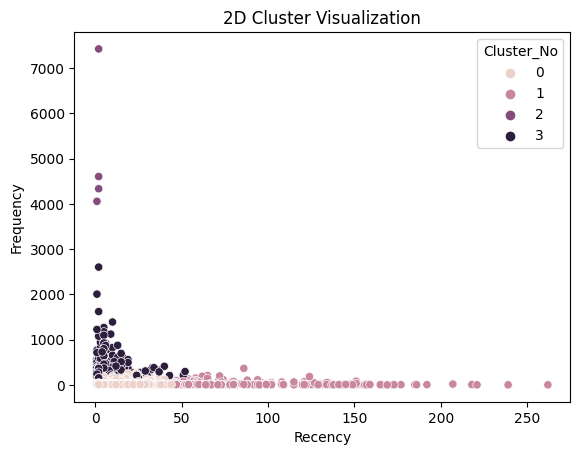

In [89]:
import seaborn as sns

# Select two features for the 2D plot
x_feature = "Recency"
y_feature = "Frequency"

# Create a new DataFrame with the selected features and cluster labels
cluster_data = rfm_metrics[[x_feature, y_feature]].copy()
cluster_data["Cluster_No"] = cluster_labels

# Visualize the clusters using Seaborn
sns.scatterplot(data=cluster_data, x=x_feature, y=y_feature, hue="Cluster_No")
plt.title("2D Cluster Visualization")
plt.show()

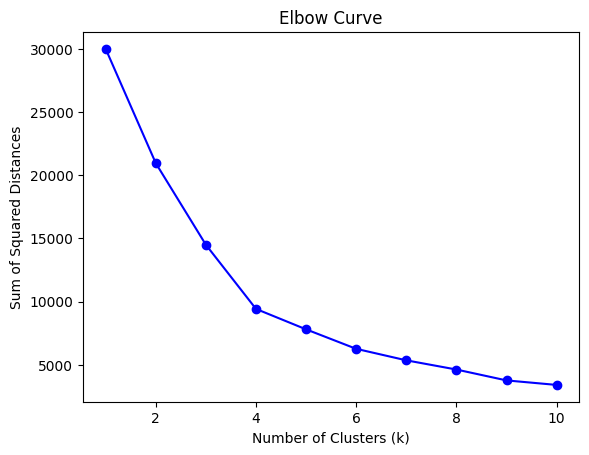

In [75]:
import matplotlib.pyplot as plt

# Perform elbow method to select the best value of k
sse = []
k_values = range(1, 11)  # Try values from 1 to 10 for k

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, sse, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve')
plt.show()

In [76]:
rfm_metrics['Cluster'] = cluster_labels

In [77]:
rfm_metrics.head()

Recency  Frequency  MonetaryValue  Cluster
CustomerID                                            
10000             9         16         100.44        0
10001             1         11          84.23        0
10002             2         12         140.08        0
10003            18          9         117.74        0
10004            15         10          44.39        0

### Summary

- The goal of this analysis was to identify distinct groups of customers based on their behavior and characteristics, in order to provide valuable insights for our marketing efforts.

- The k-means clustering model has successfully segmented our customer base into distinct clusters based on the features we considered: Recency, Frequency, and Monetary Value. This segmentation allows us to understand the different customer groups and tailor our marketing strategies accordingly. 

- Customer Segmentation: The k-means model grouped customers into clusters based on their similarities in terms of their recent purchases (Recency), frequency of purchases (Frequency), and the total monetary value of purchases (Monetary Value). Each cluster represents a distinct group of customers with similar purchasing behaviors and characteristics.

- Cluster Interpretation: By analyzing the clusters, we can gain insights into the different customer segments. For example, we may find a cluster of high-value customers who make frequent purchases and have recently engaged with our business. On the other hand, we may identify a cluster of customers who haven't made a purchase in a long time, indicating a need for re-engagement efforts.

- Targeted Marketing Strategies: With this segmentation, we can now personalize our marketing strategies to each customer cluster. We can design specific campaigns and offers tailored to the preferences and behaviors of each group. For instance, we can focus on re-engaging customers in the dormant cluster by providing incentives or exclusive offers. Meanwhile, we can reward our high-value customers with loyalty programs or VIP benefits to encourage continued loyalty and increased spending.

- Customer Lifetime Value: The clustering analysis helps us identify the most valuable customer segments in terms of their overall contribution to our business. By understanding the characteristics and behaviors of these high-value customer clusters, we can allocate our resources effectively to retain and grow these valuable customer relationships.

- In summary, the k-means clustering model allows us to gain a deeper understanding of our customer base and provides actionable insights for our marketing strategies. By personalizing our efforts and tailoring our messages to each customer segment, we can enhance customer satisfaction, increase customer loyalty, and ultimately drive business growth.


